In [220]:
%pip install lightgbm

In [221]:
# essentials
import numpy as np 
import pandas as pd 

# plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.dpi'] = 100
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="whitegrid")
%matplotlib inline

# ml
from sklearn.metrics import accuracy_score, recall_score, ConfusionMatrixDisplay, classification_report, auc, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import joblib

In [58]:
from google.colab import files
uploaded = files.upload()

Saving region_A_test.csv to region_A_test (1).csv
Saving region_B_test.csv to region_B_test (1).csv
Saving region_C_test.csv to region_C_test (1).csv
Saving region_D_test.csv to region_D_test (1).csv
Saving region_E_test.csv to region_E_test (1).csv


In [59]:
from google.colab import files
uploaded = files.upload()

Saving region_A_train.csv to region_A_train (1).csv
Saving region_B_train.csv to region_B_train (1).csv
Saving region_C_train.csv to region_C_train (1).csv
Saving region_D_train.csv to region_D_train (1).csv
Saving region_E_train.csv to region_E_train (1).csv
Saving solution_format.csv to solution_format (1).csv
Saving solution_train.csv to solution_train (1).csv


In [222]:
def print_col_type(df):
    non_num_df = df.select_dtypes(include=['object'])
    num_df = df.select_dtypes(exclude=['object'])
    '''separates non-numeric and numeric columns'''
    print("Object columns:")
    for col in non_num_df:
        print(f"{col}")
    print("")
    print("Numeric columns:")
    for col in num_df:
        print(f"{col}")

def missing_cols(df):
    '''prints out columns with its amount of missing values with its %'''
    total = 0
    for col in df.columns:
        missing_vals = df[col].isnull().sum()
        pct = df[col].isna().mean() * 100
        total += missing_vals
        if missing_vals != 0:
          print('{} => {} [{}%]'.format(col, df[col].isnull().sum(), round(pct, 2)))
    
    if total == 0:
        print("no missing values")

In [223]:
train_a = pd.read_csv("region_A_train.csv")
train_b = pd.read_csv("region_B_train.csv")
train_c = pd.read_csv("region_C_train.csv")
train_d = pd.read_csv("region_C_train.csv")
train_e = pd.read_csv("region_E_train.csv")

test_a = pd.read_csv("region_A_test.csv")
test_b = pd.read_csv("region_B_test.csv")
test_c = pd.read_csv("region_C_test.csv")
test_d = pd.read_csv("region_D_test.csv")
test_e = pd.read_csv("region_E_test.csv")

labels_df = pd.read_csv("solution_train.csv")

In [224]:
train_a.head()

,date,avg.temp,max.temp,min.temp,precipitation,avg.wind.speed,max.wind.speed,max.wind.speed.dir,max.inst.wind.speed,max.inst.wind.speed.dir,min.atmos.pressure
0,229b70a3,3.3,10.2,-2.4,0.0,2.9,9.3,W,14.3,W,1015.1
1,3134f4ff,5.7,13.7,-2.9,0.0,3.6,10.7,W,15.8,W,1011.3
2,dbfaf910,13.8,20.0,9.0,0.0,5.3,9.4,SW,15.2,W,1004.2
3,3aea0cf0,11.4,19.3,5.8,0.0,4.2,10.1,SW,20.6,SW,1001.7
4,f0227f56,2.4,7.7,0.3,43.5,0.9,3.7,SW,5.7,SW,1003.5


In [225]:
train_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     566 non-null    object 
 1   avg.temp                 566 non-null    float64
 2   max.temp                 566 non-null    float64
 3   min.temp                 566 non-null    float64
 4   precipitation            566 non-null    float64
 5   avg.wind.speed           566 non-null    float64
 6   max.wind.speed           566 non-null    float64
 7   max.wind.speed.dir       566 non-null    object 
 8   max.inst.wind.speed      566 non-null    float64
 9   max.inst.wind.speed.dir  566 non-null    object 
 10  min.atmos.pressure       566 non-null    float64
dtypes: float64(8), object(3)
memory usage: 48.8+ KB


In [226]:
print_col_type(train_a)

Object columns:
date
max.wind.speed.dir
max.inst.wind.speed.dir

Numeric columns:
avg.temp
max.temp
min.temp
precipitation
avg.wind.speed
max.wind.speed
max.inst.wind.speed
min.atmos.pressure


In [227]:
train_all = pd.concat([train_a ,train_b ,train_c ,train_d ,train_e], keys=["A", "B", "C", "D", "E"])
train_all

date  avg.temp  max.temp  min.temp  precipitation  avg.wind.speed  \
A 0    229b70a3       3.3      10.2      -2.4            0.0             2.9   
  1    3134f4ff       5.7      13.7      -2.9            0.0             3.6   
  2    dbfaf910      13.8      20.0       9.0            0.0             5.3   
  3    3aea0cf0      11.4      19.3       5.8            0.0             4.2   
  4    f0227f56       2.4       7.7       0.3           43.5             0.9   
...         ...       ...       ...       ...            ...             ...   
E 561  91b2797d       6.3      13.1       0.3            0.0             0.6   
  562  b807fd87       6.2      13.5       0.3            0.0             0.8   
  563  8e0a48e0       9.0      15.9       2.4            0.0             0.6   
  564  9df85983       5.3      13.9       0.1            0.0             1.0   
  565  c9d4fe7c       6.4      15.3      -0.2            0.0             0.7   

       max.wind.speed max.wind.speed.dir  max.inst.wind.speed  \
A 0               9.3                  W                 14.3   
  1              10.7                  W                 15.8   
  2               9.4                 SW                 15.2   
  3              10.1                 SW                 20.6   
  4               3.7                 SW                  5.7   
...               ...                ...                  ...   
E 561             2.2                  S                  4.3   
  562             2.3                 SW                  6.3   
  563             2.4                 NW                  5.7   
  564             3.0                  S                  6.9   
  565             2.1                 NW                  5.5   

      max.inst.wind.speed.dir  min.atmos.pressure  
A 0                         W              1015.1  
  1                         W              1011.3  
  2                         W              1004.2  
  3                        SW              1001.7  
  4                        SW              1003.5  
...                       ...                 ...  
E 561                       S                 NaN  
  562                       W                 NaN  
  563                       W                 NaN  
  564                      NW                 NaN  
  565                       N                 NaN  

[2830 rows x 11 columns]

In [228]:
train_all_lvls = train_all.reset_index()
train_all_lvls.rename(columns = {"level_0": "region"}, inplace=True)
train_all_lvls.drop(columns=['level_1'], inplace=True)
train_all_lvls.head()

,region,date,avg.temp,max.temp,min.temp,precipitation,avg.wind.speed,max.wind.speed,max.wind.speed.dir,max.inst.wind.speed,max.inst.wind.speed.dir,min.atmos.pressure
0,A,229b70a3,3.3,10.2,-2.4,0.0,2.9,9.3,W,14.3,W,1015.1
1,A,3134f4ff,5.7,13.7,-2.9,0.0,3.6,10.7,W,15.8,W,1011.3
2,A,dbfaf910,13.8,20.0,9.0,0.0,5.3,9.4,SW,15.2,W,1004.2
3,A,3aea0cf0,11.4,19.3,5.8,0.0,4.2,10.1,SW,20.6,SW,1001.7
4,A,f0227f56,2.4,7.7,0.3,43.5,0.9,3.7,SW,5.7,SW,1003.5


In [229]:
train_all_lvls['region'].nunique()

5

In [230]:
train_all_lvls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830 entries, 0 to 2829
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   region                   2830 non-null   object 
 1   date                     2830 non-null   object 
 2   avg.temp                 2830 non-null   float64
 3   max.temp                 2830 non-null   float64
 4   min.temp                 2830 non-null   float64
 5   precipitation            2830 non-null   float64
 6   avg.wind.speed           2830 non-null   float64
 7   max.wind.speed           2830 non-null   float64
 8   max.wind.speed.dir       2830 non-null   object 
 9   max.inst.wind.speed      2830 non-null   float64
 10  max.inst.wind.speed.dir  2830 non-null   object 
 11  min.atmos.pressure       566 non-null    float64
dtypes: float64(8), object(4)
memory usage: 265.4+ KB


In [231]:
train_all_lvls.columns[2:]

Index(['avg.temp', 'max.temp', 'min.temp', 'precipitation', 'avg.wind.speed',
       'max.wind.speed', 'max.wind.speed.dir', 'max.inst.wind.speed',
       'max.inst.wind.speed.dir', 'min.atmos.pressure'],
      dtype='object')

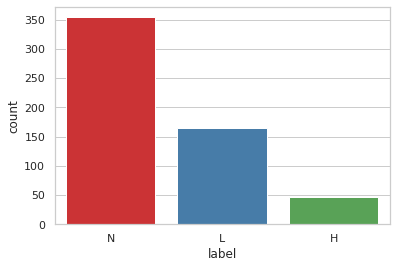

In [232]:
sns.countplot(x = 'label', data = labels_df, palette="Set1");

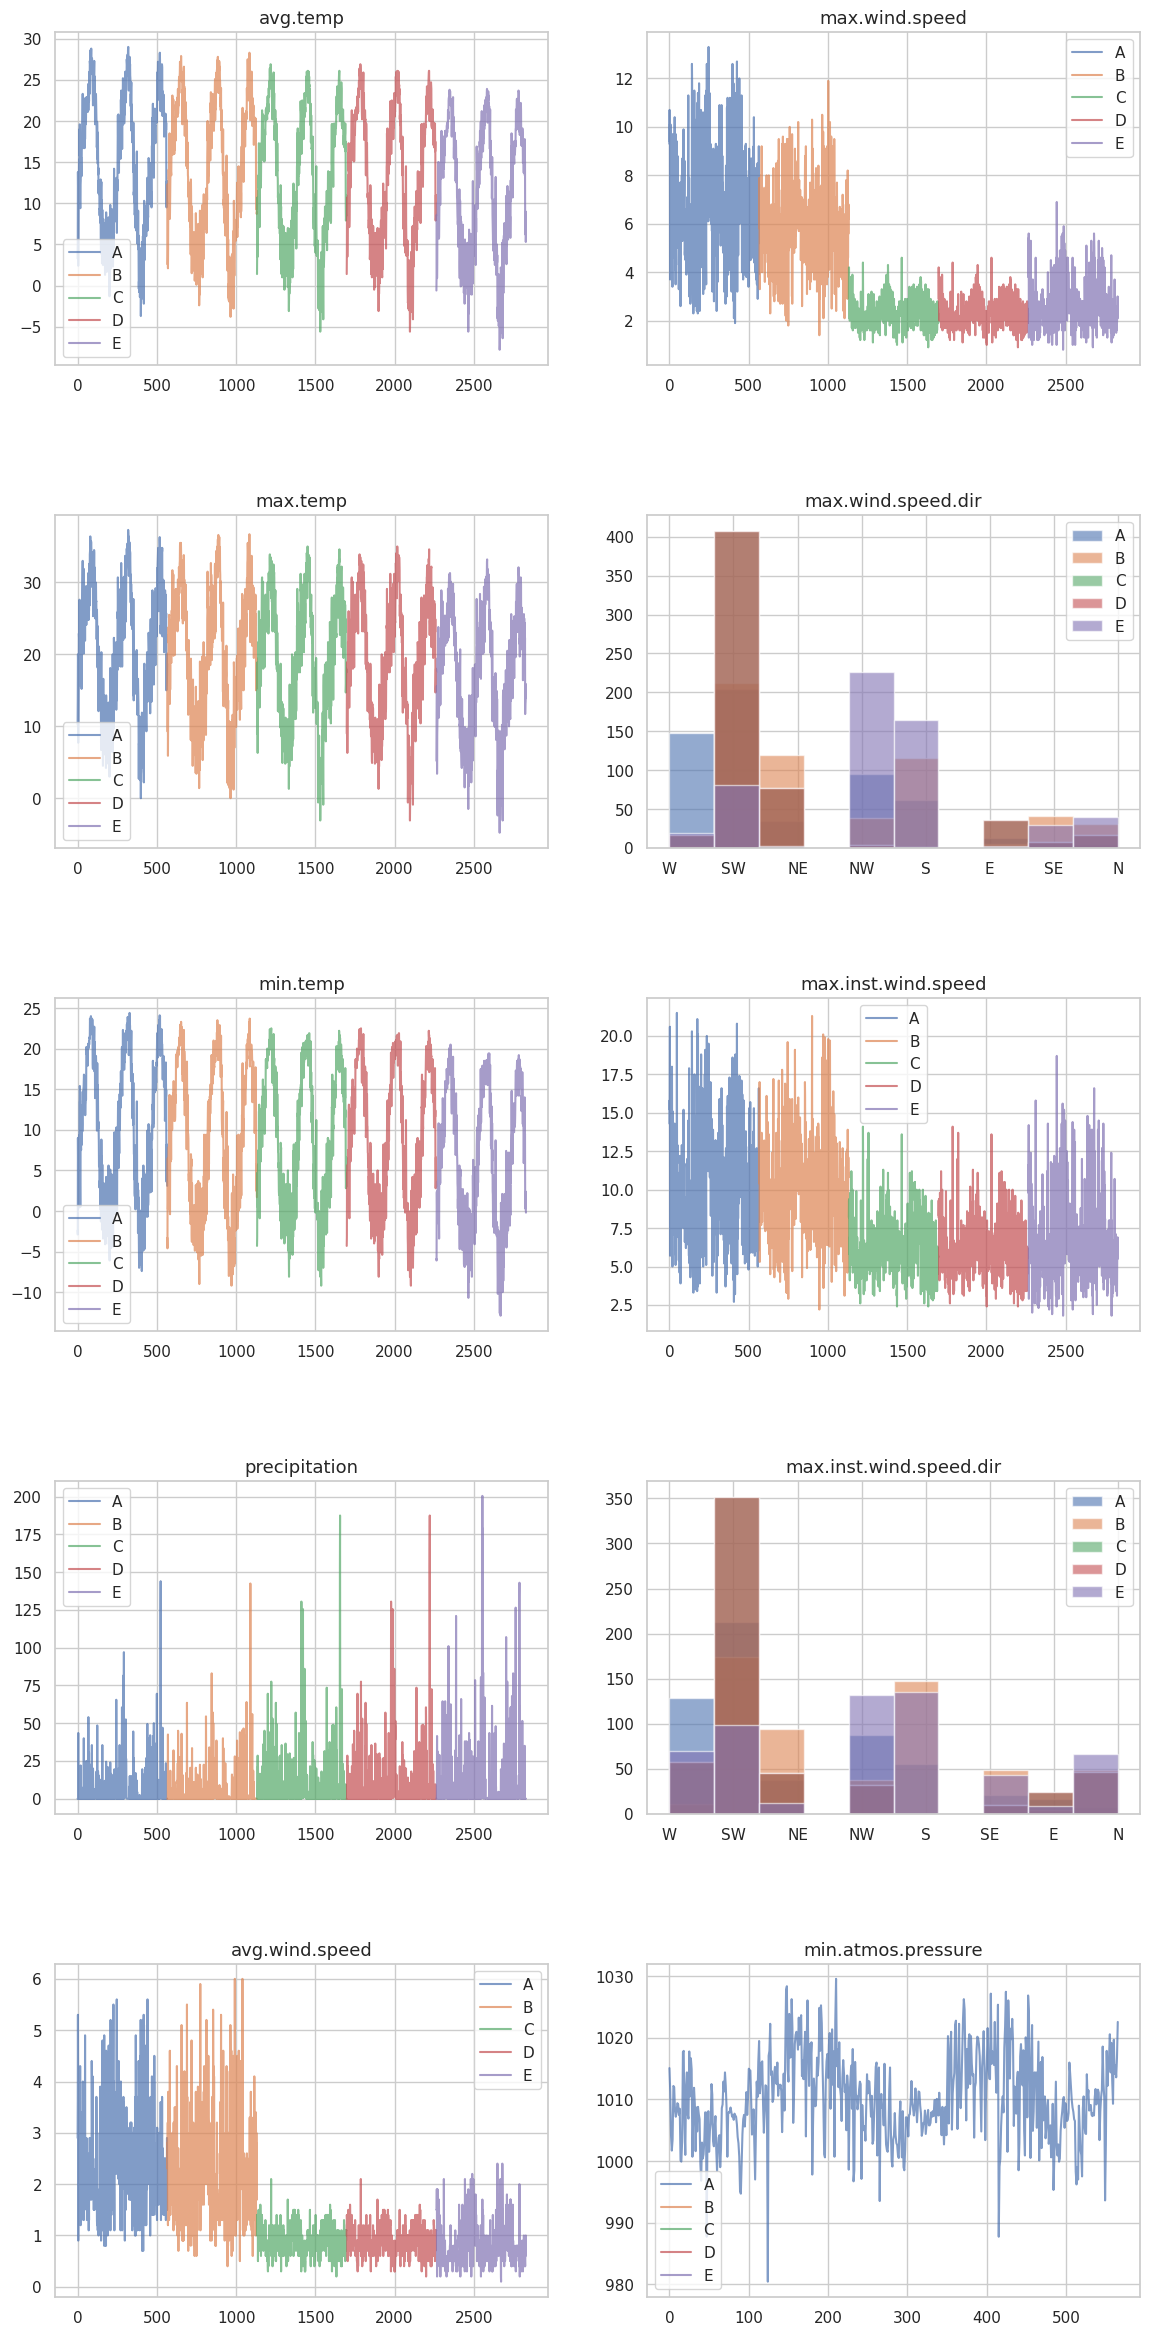

In [233]:
fig, axes = plt.subplots(5,2,figsize=(14, 30), dpi=100)

for i, col_name in enumerate(train_all_lvls.columns[2:]):
    if train_all_lvls[col_name].dtype == 'O':
        train_all_lvls.groupby('region')[col_name].hist(ax=axes[i%5][i//5], alpha=0.6);
        axes[i%5][i//5].legend(["A", "B", "C", "D", "E"]);
    else:
        train_all_lvls.groupby('region')[col_name].plot(ax=axes[i%5][i//5], alpha=0.7);
        axes[i%5][i//5].legend();
    axes[i%5][i//5].set_title(f'{col_name}', fontsize=13);
    plt.subplots_adjust(hspace=0.45)

In [234]:
test_all = pd.concat([test_a ,test_b ,test_c ,test_d ,test_e], keys=["A", "B", "C", "D", "E"])
test_all_lvls = test_all.reset_index()
test_all_lvls.rename(columns = {"level_0": "region"}, inplace=True)
test_all_lvls.drop(columns=['level_1'], inplace=True)
test_all_lvls.head()

,region,date,avg.temp,max.temp,min.temp,precipitation,avg.wind.speed,max.wind.speed,max.wind.speed.dir,max.inst.wind.speed,max.inst.wind.speed.dir,min.atmos.pressure
0,A,b92d713a,5.0,11.9,0.7,0.0,3.6,11.9,NW,16.7,NW,1009.2
1,A,18817005,2.9,9.1,-1.8,0.0,3.4,9.6,SW,15.4,SW,1013.6
2,A,8e19dc3c,9.8,18.9,0.4,0.0,3.1,8.9,W,13.6,W,1002.6
3,A,6f0929dc,13.4,21.2,6.1,0.0,3.4,8.8,SW,13.8,SW,1003.1
4,A,c7506622,9.1,16.3,2.4,0.0,2.7,7.6,NW,11.9,NW,1011.9


In [235]:
test_all_lvls = test_all.reset_index()
test_all_lvls.rename(columns = {"level_0": "region"}, inplace=True)
test_all_lvls.drop(columns=['level_1'], inplace=True)
test_all_lvls.head()

,region,date,avg.temp,max.temp,min.temp,precipitation,avg.wind.speed,max.wind.speed,max.wind.speed.dir,max.inst.wind.speed,max.inst.wind.speed.dir,min.atmos.pressure
0,A,b92d713a,5.0,11.9,0.7,0.0,3.6,11.9,NW,16.7,NW,1009.2
1,A,18817005,2.9,9.1,-1.8,0.0,3.4,9.6,SW,15.4,SW,1013.6
2,A,8e19dc3c,9.8,18.9,0.4,0.0,3.1,8.9,W,13.6,W,1002.6
3,A,6f0929dc,13.4,21.2,6.1,0.0,3.4,8.8,SW,13.8,SW,1003.1
4,A,c7506622,9.1,16.3,2.4,0.0,2.7,7.6,NW,11.9,NW,1011.9


In [236]:
test_all_lvls['region'].nunique()

5

In [237]:
test_all_lvls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1890 entries, 0 to 1889
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   region                   1890 non-null   object 
 1   date                     1890 non-null   object 
 2   avg.temp                 1888 non-null   float64
 3   max.temp                 1888 non-null   float64
 4   min.temp                 1888 non-null   float64
 5   precipitation            1888 non-null   float64
 6   avg.wind.speed           1888 non-null   float64
 7   max.wind.speed           1888 non-null   float64
 8   max.wind.speed.dir       1890 non-null   object 
 9   max.inst.wind.speed      1888 non-null   float64
 10  max.inst.wind.speed.dir  1890 non-null   object 
 11  min.atmos.pressure       378 non-null    float64
dtypes: float64(8), object(4)
memory usage: 177.3+ KB


In [238]:
test_all_lvls.columns[2:]

Index(['avg.temp', 'max.temp', 'min.temp', 'precipitation', 'avg.wind.speed',
       'max.wind.speed', 'max.wind.speed.dir', 'max.inst.wind.speed',
       'max.inst.wind.speed.dir', 'min.atmos.pressure'],
      dtype='object')

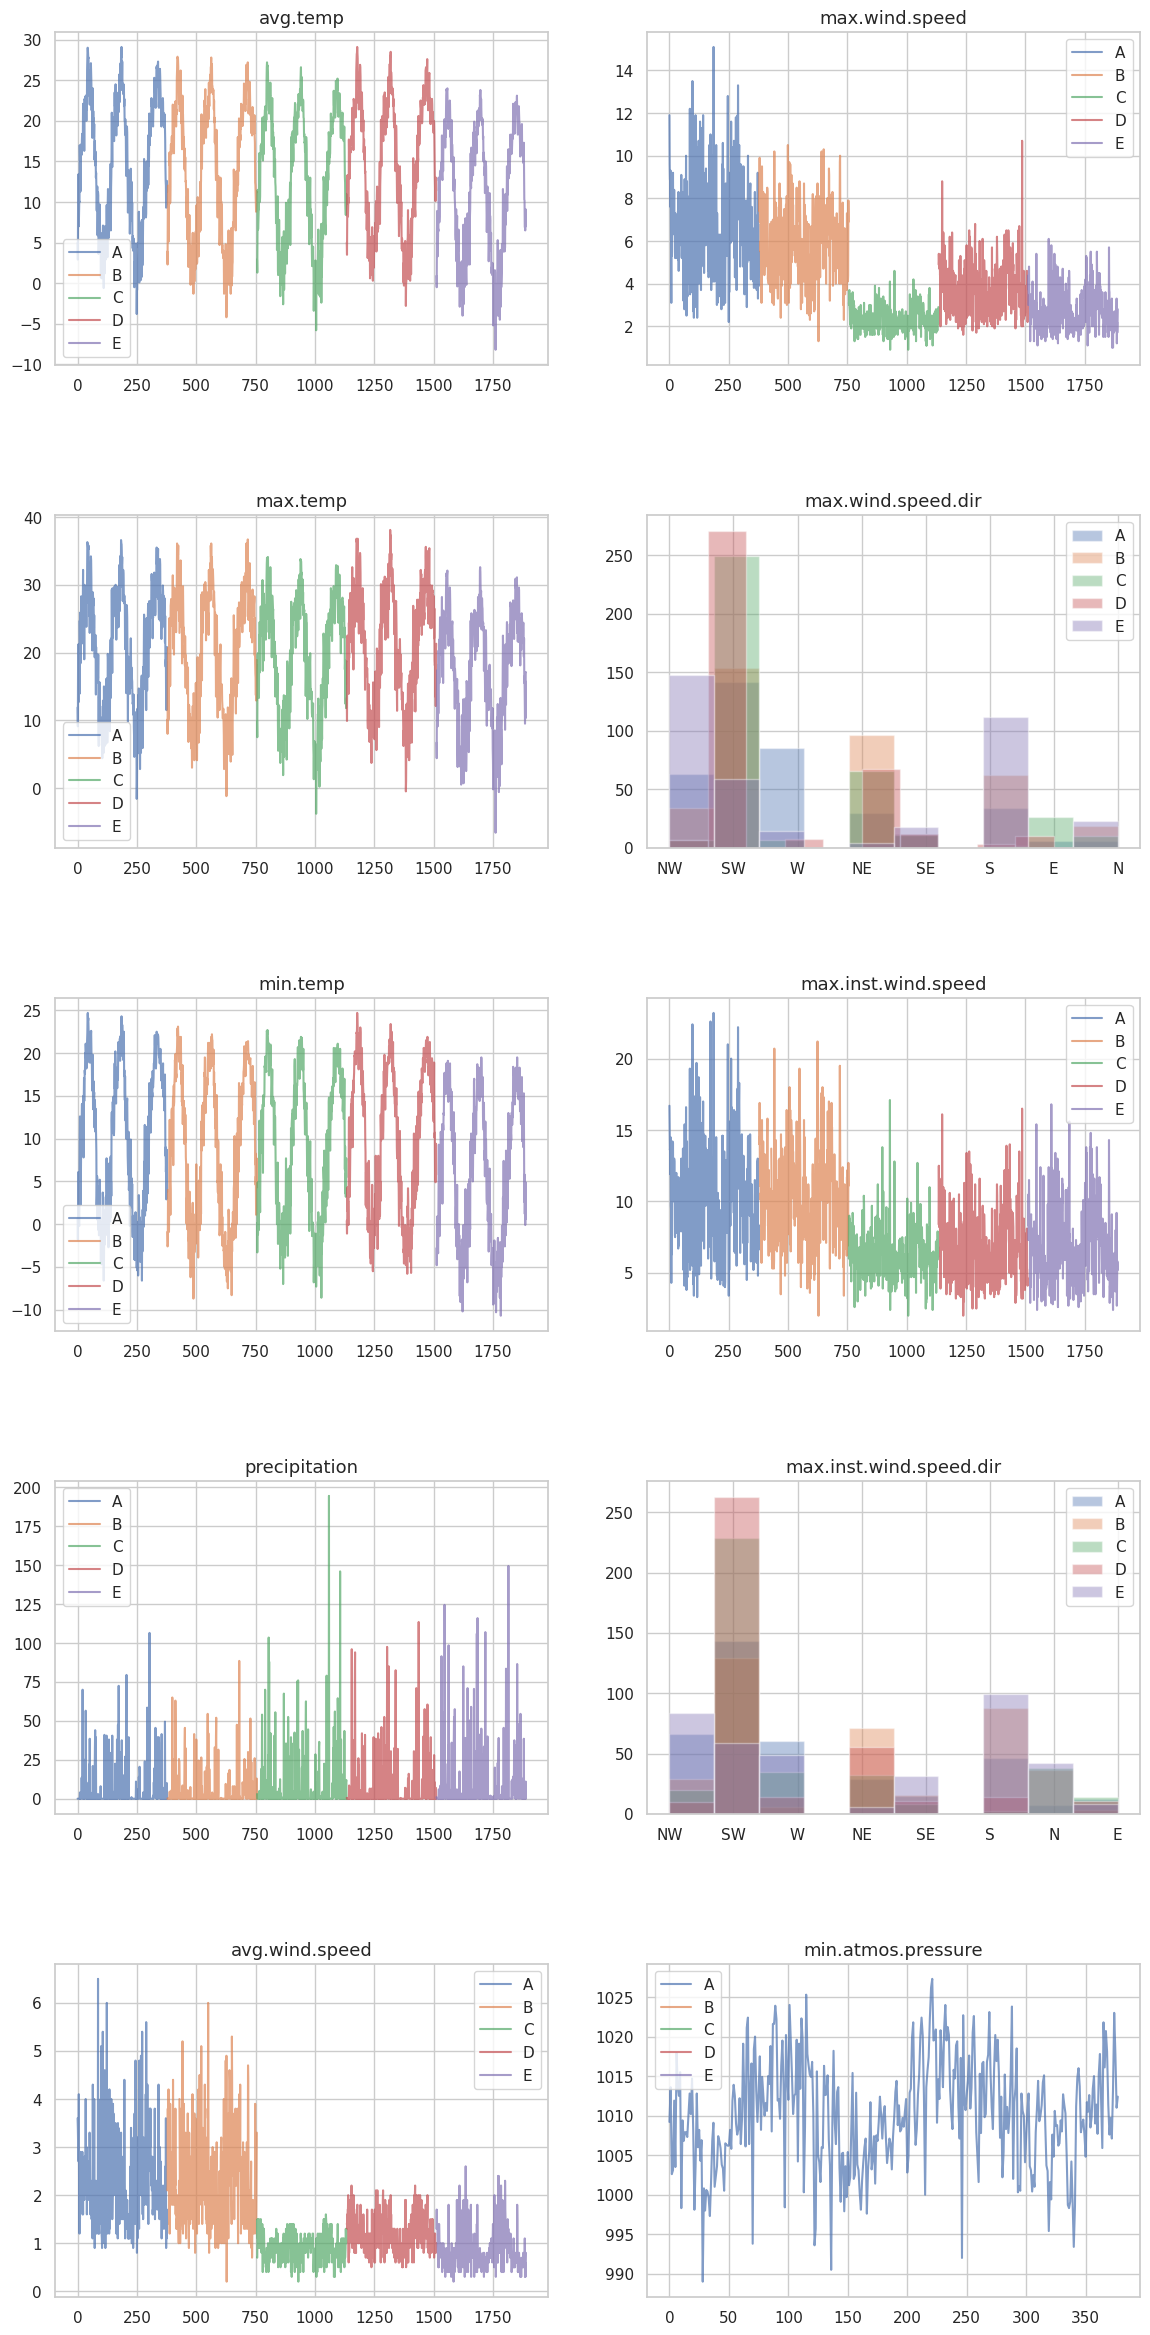

In [239]:
ig, axes = plt.subplots(5,2,figsize=(14, 30), dpi=100)

for i, col_name in enumerate(test_all_lvls.columns[2:]):
    if test_all_lvls[col_name].dtype == 'O':
        test_all_lvls.groupby('region')[col_name].hist(ax=axes[i%5][i//5], alpha=0.4);
        axes[i%5][i//5].legend(["A", "B", "C", "D", "E"]);
    else:
        test_all_lvls.groupby('region')[col_name].plot(ax=axes[i%5][i//5], alpha=0.7);
        axes[i%5][i//5].legend();
    axes[i%5][i//5].set_title(f'{col_name}', fontsize=13);
    plt.subplots_adjust(hspace=0.45)

In [240]:
missing_cols(train_all_lvls)

min.atmos.pressure => 2264 [80.0%]


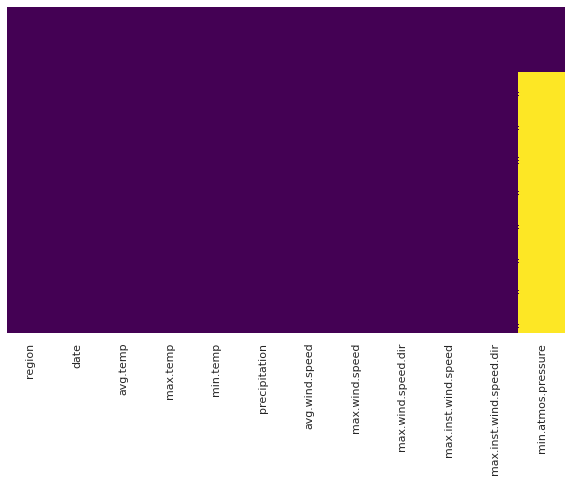

In [241]:
plt.figure(figsize=(10, 6))
sns.heatmap(train_all_lvls.isnull(), yticklabels=False, cmap='viridis', cbar=False);

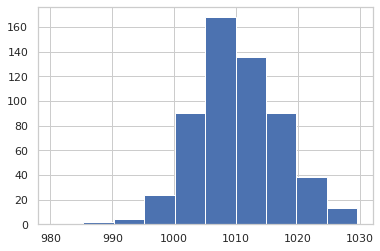

In [242]:
train_all_lvls['min.atmos.pressure'].hist();

In [244]:
mean_atmos = train_all_lvls['min.atmos.pressure'].mean()
train_all_lvls.fillna(mean_atmos, inplace=True)

In [245]:
missing_cols(train_all_lvls)

no missing values


In [246]:
missing_cols(test_all_lvls)

avg.temp => 2 [0.11%]
max.temp => 2 [0.11%]
min.temp => 2 [0.11%]
precipitation => 2 [0.11%]
avg.wind.speed => 2 [0.11%]
max.wind.speed => 2 [0.11%]
max.inst.wind.speed => 2 [0.11%]
min.atmos.pressure => 1512 [80.0%]


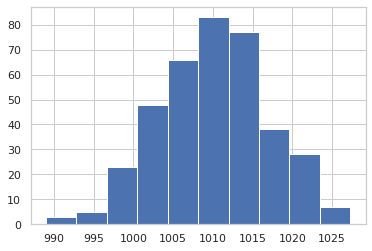

In [247]:
test_all_lvls['min.atmos.pressure'].hist();

In [248]:
mean_atmos = test_all_lvls['min.atmos.pressure'].mean()
test_all_lvls.fillna(mean_atmos, inplace=True)

In [249]:
missing_cols(test_all_lvls)

no missing values


In [250]:
train_all_lvls = train_all_lvls.merge(labels_df, on="date")

In [251]:
train_all_lvls.dtypes

region                      object
date                        object
avg.temp                   float64
max.temp                   float64
min.temp                   float64
precipitation              float64
avg.wind.speed             float64
max.wind.speed             float64
max.wind.speed.dir          object
max.inst.wind.speed        float64
max.inst.wind.speed.dir     object
min.atmos.pressure         float64
label                       object
dtype: object

In [252]:
le = LabelEncoder()
le.fit(train_all_lvls['label'])
le_name_map = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_map

{'H': 0, 'L': 1, 'N': 2}

In [253]:
train_all_lvls.select_dtypes('object').columns

Index(['region', 'date', 'max.wind.speed.dir', 'max.inst.wind.speed.dir',
       'label'],
      dtype='object')

In [254]:
test_all_lvls.select_dtypes('object').columns

Index(['region', 'date', 'max.wind.speed.dir', 'max.inst.wind.speed.dir'], dtype='object')

In [255]:
train_all_lvls.groupby('region').describe()['avg.wind.speed']

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
A,566.0,2.377032,0.927039,0.7,1.7,2.3,2.9,5.6
B,566.0,2.277208,0.993604,0.4,1.5,2.1,2.8,6.0
C,566.0,0.912544,0.269516,0.2,0.7,0.9,1.1,2.1
D,566.0,0.912544,0.269516,0.2,0.7,0.9,1.1,2.1
E,566.0,0.840106,0.396890,0.1,0.6,0.7,1.0,2.4


In [256]:
train_all_lvls.groupby('region').describe()['max.wind.speed']

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
A,566.0,6.767491,2.221823,1.9,5.2,6.6,8.300,13.3
B,566.0,5.834806,1.711907,1.4,4.7,5.8,6.900,11.9
C,566.0,2.356184,0.600875,0.9,2.0,2.3,2.775,4.6
D,566.0,2.356184,0.600875,0.9,2.0,2.3,2.775,4.6
E,566.0,2.715724,0.978739,0.8,2.0,2.5,3.200,6.9


In [257]:
BEAUFORT = [
    (0, 0, 0.3),
    (1, 0.3, 1.6),
    (2, 1.6, 3.4),
    (3, 3.4, 5.5),
    (4, 5.5, 8),
    (5, 8, 10.8),
    (6, 10.8, 13.9),
    (7, 13.9, 17.2),
    (8, 17.2, 20.8),
    (9, 20.8, 24.5),
    (10, 24.5, 28.5),
    (11, 28.5, 33),
    (12, 33, 200),
]


def feature_eng(df):
    le = LabelEncoder()
    
    cat_cols = df.select_dtypes("object").columns[2:]

    for col in cat_cols:
        if df[col].dtype == "object":
            df[col] = le.fit_transform(df[col])

    # wind speed is in meter/second
    # convert to knots to obtain beaufort scale
    for item in BEAUFORT:
        df.loc[
            (df["avg.wind.speed"] * 1.944 >= item[1]) & (df["avg.wind.speed"] * 1.944 < item[2]),
            "avg_beaufort_scale",
        ] = item[0]
        df.loc[
            (df["max.wind.speed"] * 1.944 >= item[1]) & (df["max.wind.speed"] * 1.944 < item[2]),
            "max_beaufort_scale",
        ] = item[0]

    df['avg_beaufort_scale'] = df['avg_beaufort_scale'].astype(int)
    df['max_beaufort_scale'] = df['max_beaufort_scale'].astype(int)

    return df

In [262]:
test_all_lvls["max.wind.speed.dir"] = test_all_lvls["max.wind.speed.dir"].astype("object")

In [263]:
test_all_lvls["max.inst.wind.speed.dir"] = test_all_lvls["max.inst.wind.speed.dir"].astype("object")

In [264]:
test_all_lvls.dtypes

region                      object
date                        object
avg.temp                   float64
max.temp                   float64
min.temp                   float64
precipitation              float64
avg.wind.speed             float64
max.wind.speed             float64
max.wind.speed.dir          object
max.inst.wind.speed        float64
max.inst.wind.speed.dir     object
min.atmos.pressure         float64
avg_beaufort_scale         float64
max_beaufort_scale         float64
dtype: object

In [266]:
train = feature_eng(train_all_lvls)

In [267]:
test = feature_eng(test_all_lvls)

IntCastingNaNError: ignored